In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib   

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import seaborn as sns

# Load data
eq5d = pd.read_csv('../rq1/rq1_cleaned_no_ae.csv')
scores = pd.read_excel('../data/Scores 6 Jan 2025_Prescribed_Completed Baseline PROMs.xlsx')

gad7 = scores[scores['promName']=='GAD7'][['SID','Round','total_score']]
gad7_wide = gad7.pivot_table(index='SID', columns='Round', values='total_score', aggfunc='first')
gad7_wide.columns = [f"GAD7_Round{r}" for r in gad7_wide.columns]
gad7_wide = gad7_wide.reset_index()
gad7 = pd.merge(eq5d, gad7_wide, on='SID', how='left')

ins = scores[scores['promName']=='insomniaEfficacyMeasure'][['SID','Round','total_score']]
ins_wide = ins.pivot_table(index='SID', columns='Round', values='total_score', aggfunc='first')
ins_wide.columns = [f"insomniaEfficacyMeasure_Round{r}" for r in ins_wide.columns]
ins_wide = ins_wide.reset_index()
full = pd.merge(gad7, ins_wide, on='SID', how='left')


# Prepare features and target
drop_cols = [
    'SID', 'GAD7_Round2','GAD7_Round3','GAD7_Round4','GAD7_Round5','GAD7_Round6','GAD7_Round7',
    'GAD7_Round8','GAD7_Round9','GAD7_Round10','GAD7_Round11','GAD7_Round12',
    'GAD7_Round13', 'EQ5D_Round2','EQ5D_Round3','EQ5D_Round4','EQ5D_Round5',
    'EQ5D_Round6', 'insomniaEfficacyMeasure_Round2','insomniaEfficacyMeasure_Round3',
    'insomniaEfficacyMeasure_Round4','insomniaEfficacyMeasure_Round5',
    'insomniaEfficacyMeasure_Round6','insomniaEfficacyMeasure_Round7',
    'insomniaEfficacyMeasure_Round8','insomniaEfficacyMeasure_Round9',
    'insomniaEfficacyMeasure_Round10','insomniaEfficacyMeasure_Round11',
    'insomniaEfficacyMeasure_Round12','insomniaEfficacyMeasure_Round13', 'GAD7_Round1_y', 'insomniaEfficacyMeasure_Round1_y'
]
X = full.drop(columns=drop_cols)
y = full['GAD7_Round2']
data = pd.concat([X, y], axis=1).dropna()
X, y = data.drop(columns='GAD7_Round2'), data['GAD7_Round2']

X=X.rename(columns={
    'GAD7_Round1_x': 'GAD7_Round1',
    'insomniaEfficacyMeasure_Round1_x': 'insomniaEfficacyMeasure_Round1'})


In [6]:
full.columns.tolist()

['SID',
 'EQ5D_Round1',
 'EQ5D_Round2',
 'EQ5D_Round3',
 'EQ5D_Round4',
 'EQ5D_Round5',
 'EQ5D_Round6',
 'Age',
 'Sex',
 'occupation',
 'weight',
 'height',
 'Myocardial_infarction',
 'Congestive_heart_failure',
 'Peripheral_vascular_disease',
 'Cerebrovascular_accident_or_transient_ischemic_attack',
 'Dementia',
 'Chronic_obstructive_pulmonary_disease',
 'Connective_tissue_disease',
 'Peptic_Ulcer_Disease',
 'Liver_disease',
 'Diabetes',
 'Hemiplegia',
 'Moderate_to_severe_chronic_kidney_disease',
 'Solid_tumour',
 'Leukemia',
 'Lymphoma',
 'AIDS',
 'Charlson_comorbidity',
 'Hypertension',
 'Depression_or_anxiety',
 'Arthritis',
 'Epilepsy',
 'VTE',
 'Endocrine_thyroid_dysfunction',
 'Allergy',
 'Smoking_status',
 'Smoking_pack_years',
 'alcohol_units',
 'Cannabis_status',
 'GAD7_Round1_x',
 'insomniaEfficacyMeasure_Round1_x',
 'diag_Depression',
 'diag_Anxiety',
 'diag_Chronic pain',
 'diag_Osteoarthritis',
 'diag_PTSD',
 'diag_Fibromyalgia',
 'diag_Multiple sclerosis',
 'diag_Neurop

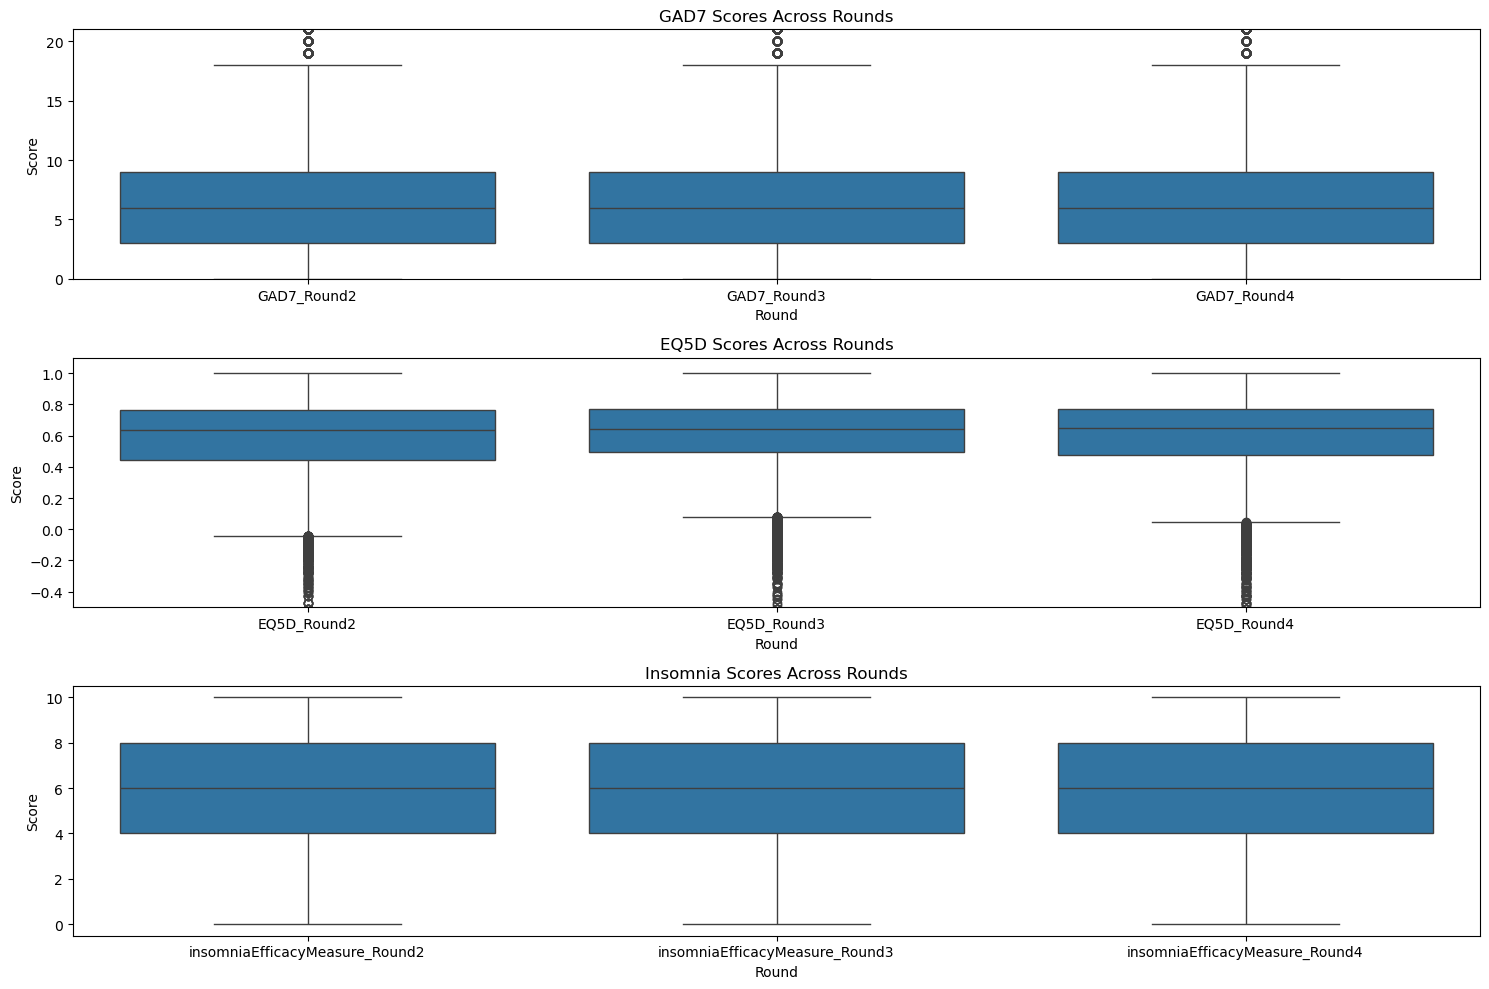

In [8]:
# First ensure we only keep rows with non-null values for the rounds we're analyzing
filtered = full[['GAD7_Round2', 'GAD7_Round3', 'GAD7_Round4',
                'EQ5D_Round2', 'EQ5D_Round3', 'EQ5D_Round4',
                'insomniaEfficacyMeasure_Round2', 'insomniaEfficacyMeasure_Round3',
                'insomniaEfficacyMeasure_Round4']].dropna()

# Melt data for boxplot - now using the filtered data
melted_gad = filtered.melt(value_vars=['GAD7_Round2', 'GAD7_Round3', 'GAD7_Round4'], 
                          var_name='Round', value_name='Score')
melted_gad['Metric'] = 'GAD7'

melted_eq5d = filtered.melt(value_vars=['EQ5D_Round2', 'EQ5D_Round3', 'EQ5D_Round4'], 
                           var_name='Round', value_name='Score')
melted_eq5d['Metric'] = 'EQ5D'

melted_ins = filtered.melt(value_vars=['insomniaEfficacyMeasure_Round2', 
                                     'insomniaEfficacyMeasure_Round3',
                                     'insomniaEfficacyMeasure_Round4'], 
                          var_name='Round', value_name='Score')
melted_ins['Metric'] = 'Insomnia'

# Combine the melted DataFrames
combined = pd.concat([melted_gad, melted_eq5d, melted_ins])

# Create subplots for better visualization
plt.figure(figsize=(15, 10))

# GAD7 Plot
plt.subplot(3, 1, 1)
sns.boxplot(data=combined[combined['Metric'] == 'GAD7'], 
            x='Round', y='Score')
plt.title('GAD7 Scores Across Rounds')
plt.ylim(0, 21)  # GAD7 range

# EQ5D Plot
plt.subplot(3, 1, 2)
sns.boxplot(data=combined[combined['Metric'] == 'EQ5D'], 
            x='Round', y='Score')
plt.title('EQ5D Scores Across Rounds')
plt.ylim(-0.5, 1.1)  # EQ5D range

# Insomnia Plot
plt.subplot(3, 1, 3)
sns.boxplot(data=combined[combined['Metric'] == 'Insomnia'], 
            x='Round', y='Score')
plt.title('Insomnia Scores Across Rounds')

plt.tight_layout()
plt.show()


GAD7 Mean Scores:
GAD7_Round2: 6.62
GAD7_Round3: 6.46
GAD7_Round4: 6.45

EQ5D Mean Scores:
EQ5D_Round2: 0.58
EQ5D_Round3: 0.59
EQ5D_Round4: 0.59

Insomnia Mean Scores:
insomniaEfficacyMeasure_Round2: 5.71
insomniaEfficacyMeasure_Round3: 5.71
insomniaEfficacyMeasure_Round4: 5.68


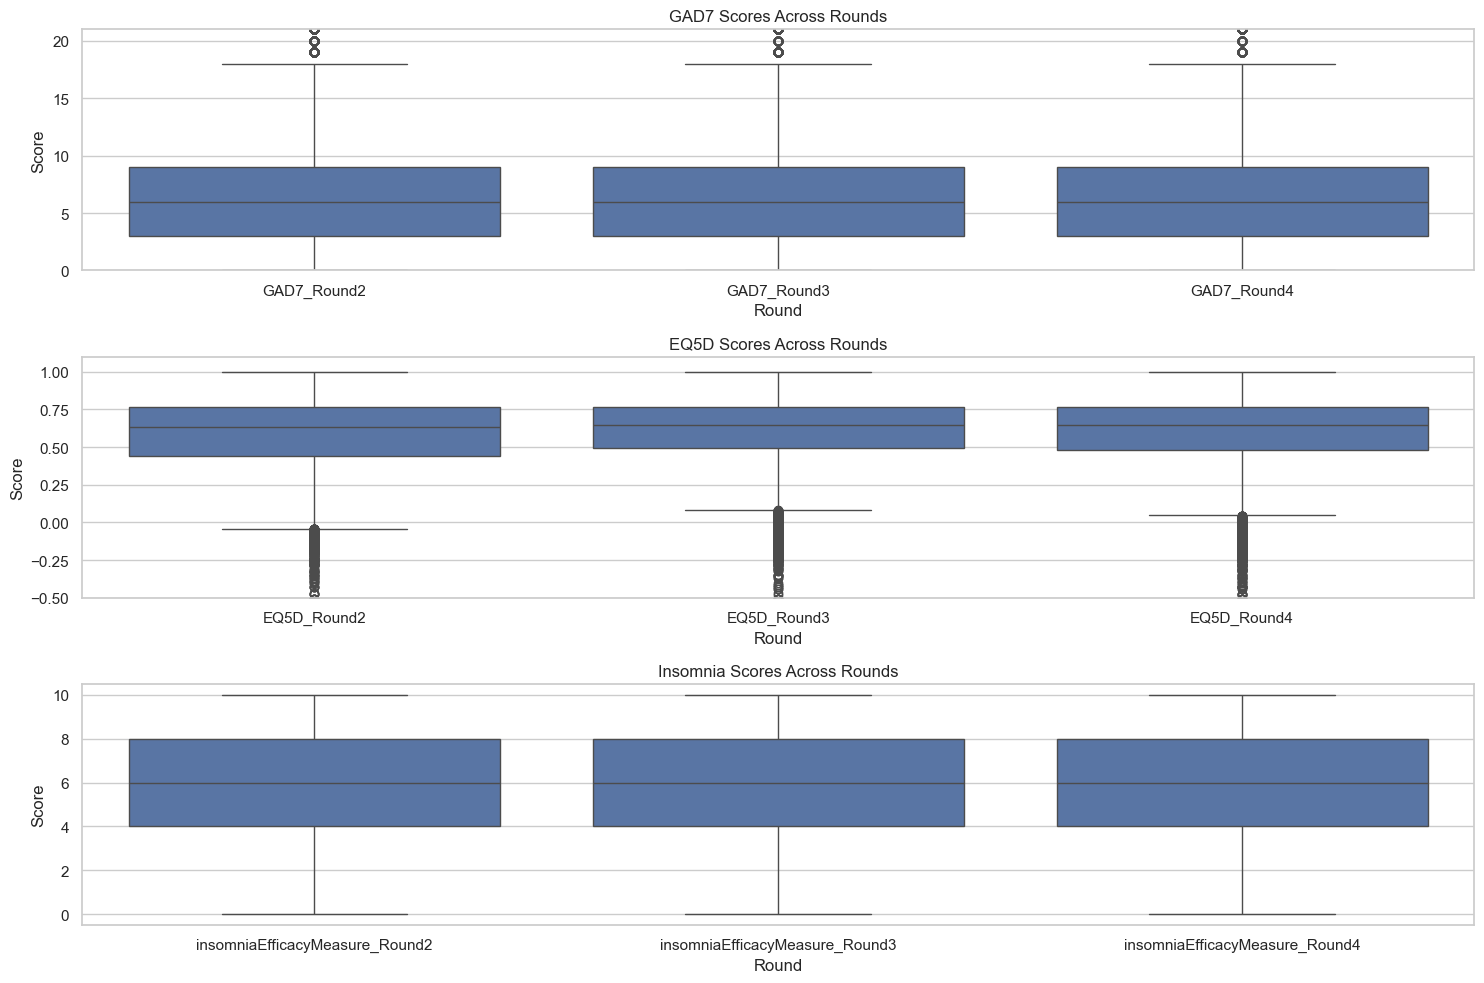

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate and print means for each metric
def print_means(df, metric_name, round_cols):
    print(f"\n{metric_name} Mean Scores:")
    for col in round_cols:
        print(f"{col}: {df[col].mean():.2f}")

# GAD7
print_means(filtered, "GAD7", ['GAD7_Round2', 'GAD7_Round3', 'GAD7_Round4'])

# EQ5D
print_means(filtered, "EQ5D", ['EQ5D_Round2', 'EQ5D_Round3', 'EQ5D_Round4'])

# Insomnia
print_means(filtered, "Insomnia", ['insomniaEfficacyMeasure_Round2', 
                                  'insomniaEfficacyMeasure_Round3',
                                  'insomniaEfficacyMeasure_Round4'])

# Create the visualization (same as before)
plt.figure(figsize=(15, 10))

# GAD7 Plot
plt.subplot(3, 1, 1)
sns.boxplot(data=combined[combined['Metric'] == 'GAD7'], 
            x='Round', y='Score')
plt.title('GAD7 Scores Across Rounds')
plt.ylim(0, 21)

# EQ5D Plot
plt.subplot(3, 1, 2)
sns.boxplot(data=combined[combined['Metric'] == 'EQ5D'], 
            x='Round', y='Score')
plt.title('EQ5D Scores Across Rounds')
plt.ylim(-0.5, 1.1)

# Insomnia Plot
plt.subplot(3, 1, 3)
sns.boxplot(data=combined[combined['Metric'] == 'Insomnia'], 
            x='Round', y='Score')
plt.title('Insomnia Scores Across Rounds')

plt.tight_layout()
plt.show()

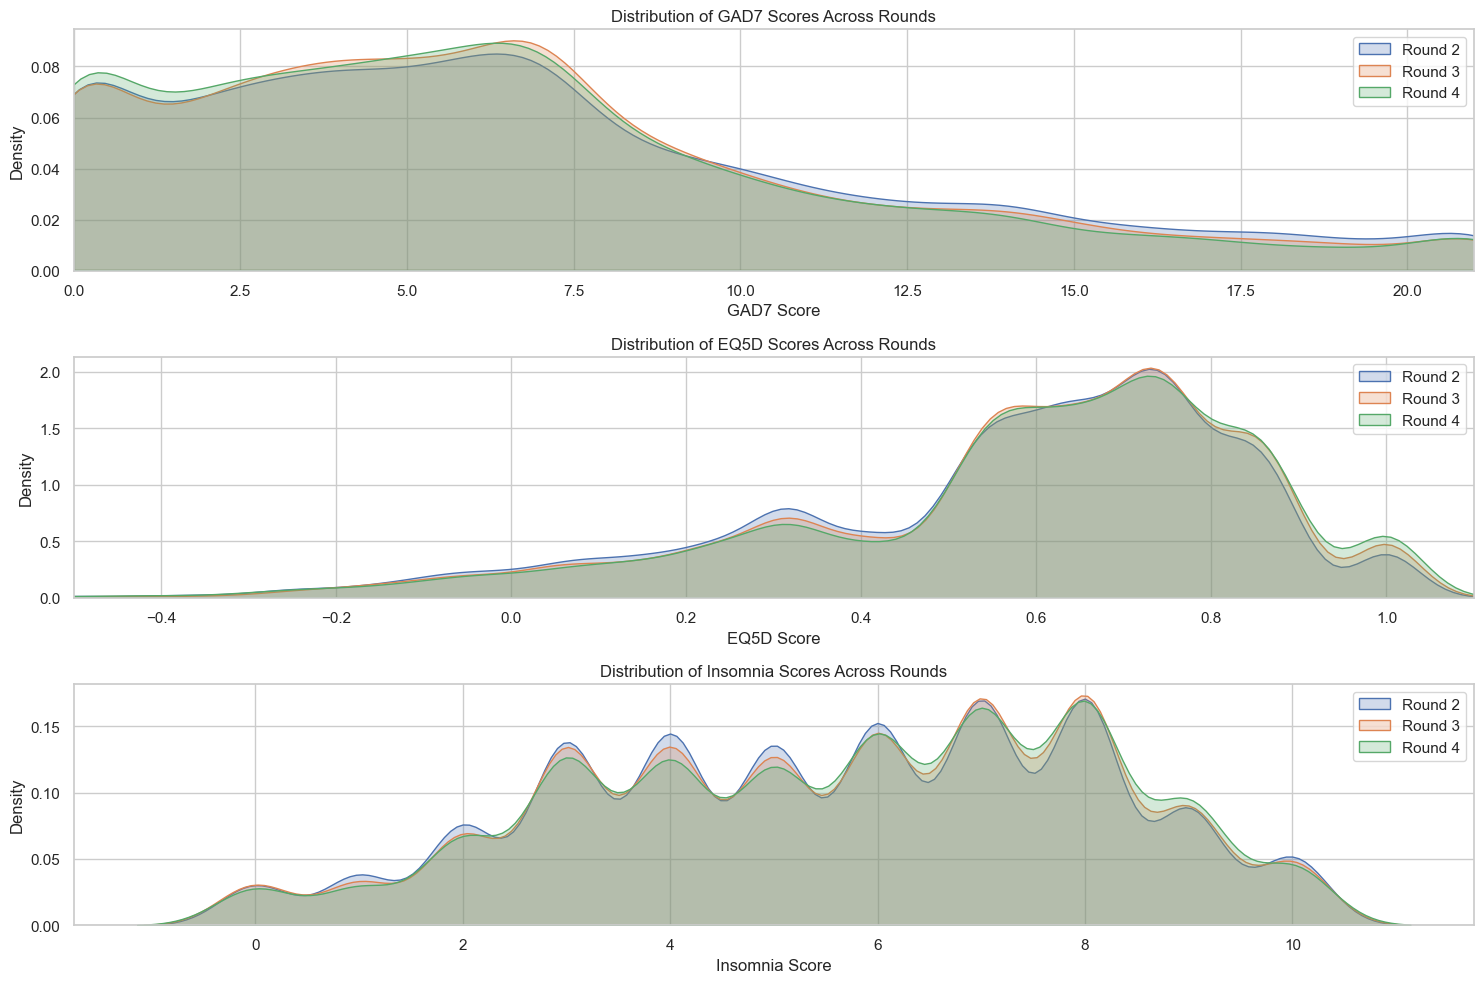

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

# =====================
# GAD7 Distribution
# =====================
plt.subplot(3, 1, 1)
sns.kdeplot(data=full, x='GAD7_Round2', label='Round 2', fill=True)
sns.kdeplot(data=full, x='GAD7_Round3', label='Round 3', fill=True)
sns.kdeplot(data=full, x='GAD7_Round4', label='Round 4', fill=True)
plt.title('Distribution of GAD7 Scores Across Rounds')
plt.xlabel('GAD7 Score')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, 21)  # GAD7 range is 0-21

# =====================
# EQ5D Distribution
# =====================
plt.subplot(3, 1, 2)
sns.kdeplot(data=full, x='EQ5D_Round2', label='Round 2', fill=True)
sns.kdeplot(data=full, x='EQ5D_Round3', label='Round 3', fill=True)
sns.kdeplot(data=full, x='EQ5D_Round4', label='Round 4', fill=True)
plt.title('Distribution of EQ5D Scores Across Rounds')
plt.xlabel('EQ5D Score')
plt.ylabel('Density')
plt.legend()
plt.xlim(-0.5, 1.1)  # EQ5D range is typically -0.5 to 1.0

# =====================
# Insomnia Distribution
# =====================
plt.subplot(3, 1, 3)
sns.kdeplot(data=full, x='insomniaEfficacyMeasure_Round2', label='Round 2', fill=True)
sns.kdeplot(data=full, x='insomniaEfficacyMeasure_Round3', label='Round 3', fill=True)
sns.kdeplot(data=full, x='insomniaEfficacyMeasure_Round4', label='Round 4', fill=True)
plt.title('Distribution of Insomnia Scores Across Rounds')
plt.xlabel('Insomnia Score')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

In [3]:
print(X['Charlson_comorbidity'].value_counts())

Charlson_comorbidity
0     14248
6      2606
1       998
5       818
7       493
2       345
3       343
8       220
4       133
9       118
12       70
10       53
11       52
27       22
13       17
33        5
24        3
16        3
15        3
32        2
14        2
18        1
17        1
19        1
Name: count, dtype: int64


In [2]:
X.columns.tolist() 

['EQ5D_Round1',
 'Age',
 'Sex',
 'occupation',
 'weight',
 'height',
 'Myocardial_infarction',
 'Congestive_heart_failure',
 'Peripheral_vascular_disease',
 'Cerebrovascular_accident_or_transient_ischemic_attack',
 'Dementia',
 'Chronic_obstructive_pulmonary_disease',
 'Connective_tissue_disease',
 'Peptic_Ulcer_Disease',
 'Liver_disease',
 'Diabetes',
 'Hemiplegia',
 'Moderate_to_severe_chronic_kidney_disease',
 'Solid_tumour',
 'Leukemia',
 'Lymphoma',
 'AIDS',
 'Charlson_comorbidity',
 'Hypertension',
 'Depression_or_anxiety',
 'Arthritis',
 'Epilepsy',
 'VTE',
 'Endocrine_thyroid_dysfunction',
 'Allergy',
 'Smoking_status',
 'Smoking_pack_years',
 'alcohol_units',
 'Cannabis_status',
 'GAD7_Round1_x',
 'insomniaEfficacyMeasure_Round1_x',
 'diag_Depression',
 'diag_Anxiety',
 'diag_Chronic pain',
 'diag_Osteoarthritis',
 'diag_PTSD',
 'diag_Fibromyalgia',
 'diag_Multiple sclerosis',
 'diag_Neuropathic pain',
 'diag_Attention deficit hyperactivity disorder',
 'diag_Migraine',
 'diag_

In [5]:
!pip install joblib